In [17]:
%reload_ext autoreload
%autoreload 2

import time
from tqdm import tqdm
import numpy as np
import scipy as sp
import torch
import torch.nn.functional as F
from torch import nn
from torchvision import transforms

from matplotlib import pyplot as plt

from networkAlignmentAnalysis.models.models import MLP, CNN2P2, AlexNet
from networkAlignmentAnalysis import utils
from networkAlignmentAnalysis import datasets

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print('using device: ', DEVICE)

using device:  cuda


In [18]:
def gray_to_rgb(x):
    return x.repeat(1, 3, 1, 1)

preprocess = transforms.Compose([
            transforms.ToTensor(), # first, convert image to PyTorch tensor
            transforms.Normalize((0.1307,), (0.3081,)), # normalize inputs
            # transforms.Resize((224, 224)),
            transforms.Lambda(torch.flatten), # convert to vectors
        ])
trainloader, testloader = datasets.downloadMNIST(batchSize=1024, preprocess=preprocess)

In [19]:
net = MLP()
# net = CNN2P2()
# net = AlexNet()
net.to(DEVICE)
    
# Prepare Training Functions 
loss_function = nn.CrossEntropyLoss() # Note: this automatically applies softmax...
# optimizer = torch.optim.SGD(net.parameters(), lr=1e-1)
# optimizer = torch.optim.Adadelta(net.parameters())
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

# Preallocate summary variables  
iterations = 20
numTrainingSteps = len(trainloader)*iterations
trackLoss = torch.zeros(numTrainingSteps)
trackAccuracy = torch.zeros(numTrainingSteps)
alignFull = []
deltaWeights = []

init_weights = net.get_alignment_weights()

# Train Network & Measure Integration
t = time.time()
for epoch in range(0, iterations): 
    print('iteration: ', epoch)
    
    # Set current loss value
    currentLoss = 0.0
    numBatches = 0
    currentCorrect = 0
    currentAttempted = 0

    for idx,batch in tqdm(enumerate(trainloader)):
        cidx = epoch*len(trainloader) + idx
        
        images, label = batch
        # images = gray_to_rgb(images)
        images = images.to(DEVICE)
        label = label.to(DEVICE)

        # Zero the gradients
        optimizer.zero_grad()

        # Perform forward pass
        outputs = net(images, store_hidden=True)

        # Perform backward pass & optimization
        loss = loss_function(outputs, label)
        loss.backward()
        optimizer.step()

        # Track Loss and Accuracy
        trackLoss[cidx] = loss.item()
        trackAccuracy[cidx] = 100*torch.sum(torch.argmax(outputs,axis=1)==label)/images.shape[0]

        # Measure Integration
        alignFull.append(net.measure_alignment(images, precomputed=True, method='alignment'))
        
        # Measure Change in Weights
        deltaWeights.append(net.compare_weights(init_weights))

    # Print statistics for each epoch
    print('Loss in epoch %3d: %.3f, Accuracy: %.2f%%.' % (epoch, loss.item(), 100*torch.sum(torch.argmax(outputs,axis=1)==label)/images.shape[0]))


iteration:  0


59it [00:03, 15.38it/s]


Loss in epoch   0: 0.844, Accuracy: 73.68%.
iteration:  1


59it [00:03, 15.40it/s]


Loss in epoch   1: 0.513, Accuracy: 85.53%.
iteration:  2


59it [00:03, 15.43it/s]


Loss in epoch   2: 0.489, Accuracy: 86.35%.
iteration:  3


59it [00:03, 15.58it/s]


Loss in epoch   3: 0.328, Accuracy: 90.79%.
iteration:  4


59it [00:03, 15.40it/s]


Loss in epoch   4: 0.359, Accuracy: 89.14%.
iteration:  5


59it [00:03, 15.31it/s]


Loss in epoch   5: 0.337, Accuracy: 90.46%.
iteration:  6


59it [00:03, 15.45it/s]


Loss in epoch   6: 0.317, Accuracy: 93.26%.
iteration:  7


59it [00:03, 15.55it/s]


Loss in epoch   7: 0.362, Accuracy: 91.94%.
iteration:  8


59it [00:03, 15.46it/s]


Loss in epoch   8: 0.274, Accuracy: 92.11%.
iteration:  9


59it [00:03, 15.53it/s]


Loss in epoch   9: 0.248, Accuracy: 93.09%.
iteration:  10


59it [00:03, 15.42it/s]


Loss in epoch  10: 0.274, Accuracy: 92.93%.
iteration:  11


59it [00:03, 15.49it/s]


Loss in epoch  11: 0.254, Accuracy: 93.26%.
iteration:  12


59it [00:03, 15.28it/s]


Loss in epoch  12: 0.331, Accuracy: 92.11%.
iteration:  13


59it [00:03, 15.42it/s]


Loss in epoch  13: 0.225, Accuracy: 93.91%.
iteration:  14


59it [00:03, 15.06it/s]


Loss in epoch  14: 0.270, Accuracy: 93.09%.
iteration:  15


59it [00:03, 15.21it/s]


Loss in epoch  15: 0.255, Accuracy: 92.93%.
iteration:  16


59it [00:03, 15.43it/s]


Loss in epoch  16: 0.221, Accuracy: 93.75%.
iteration:  17


59it [00:03, 15.16it/s]


Loss in epoch  17: 0.211, Accuracy: 95.23%.
iteration:  18


59it [00:03, 15.24it/s]


Loss in epoch  18: 0.224, Accuracy: 94.24%.
iteration:  19


59it [00:03, 14.98it/s]

Loss in epoch  19: 0.208, Accuracy: 93.75%.


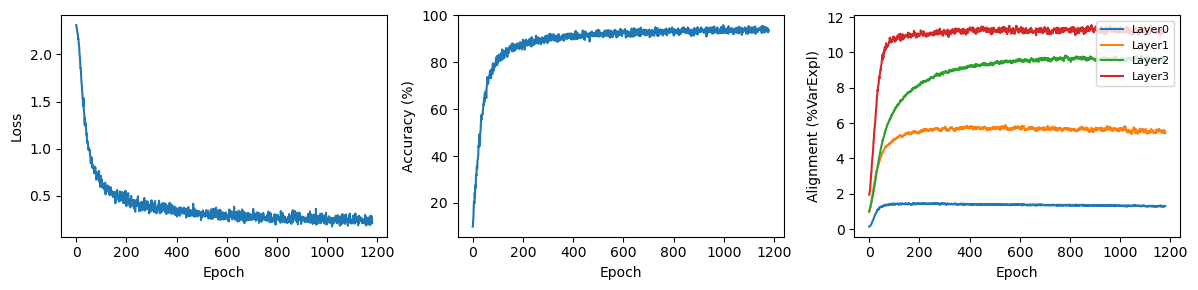

In [20]:
# This code plots absolute values of loss, accuracy, similarity, and integration
# -- useful for knowing what the true (unnormalized) values are --
numEpoch = trackLoss.shape[0]
alignMean = utils.avg_from_full(alignFull)

# Note: similarity and integration are only current -- I changed it to simMean,intMean,simStd,intStd for future reference and for plotting error bars!
fig,ax = plt.subplots(1,3,figsize=(12,3))
ax[0].plot(trackLoss)
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[1].plot(trackAccuracy)
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy (%)')
for i in range(alignMean.shape[0]):
    ax[2].plot(alignMean[i,:]*100,label=f'Layer{i}')
ax[2].set_xlabel('Epoch')
ax[2].set_ylabel('Alignment (%VarExpl)')
ax[2].legend(fontsize=8, loc='upper right')

plt.tight_layout()

In [8]:
# TODO
# 1.1. include additional AlignmentModel methods stored in extra class in base model
# -- the measure_eigenfeature method is baaaaad -- because it doesn't account for convolutional layers
# -- I should consider weighing the each_stride average by the average norm of the input in that stride...
# 2. Make datasets a class
# 3. Make training a nice method
# 4. Rewrite existing analysis pipelines
# 5. SLURM!!!!

In [23]:
fraction_dropout = 0.33
idx_alignment = [torch.argsort(-align) for align in alignFull[-1]]
idx_align_high = [idx[:int(len(idx)*fraction_dropout)] for idx in idx_alignment]
idx_align_low = [idx[-int(len(idx)*fraction_dropout):] for idx in idx_alignment]
out_no_low, _ = net.forward_targeted_dropout(images, idx_align_low[:-1], range(len(idx_align_low)-1))
out_no_high, _ = net.forward_targeted_dropout(images, idx_align_high[:-1], range(len(idx_align_high)-1))
out = net(images)

loss_no_low = loss_function(out_no_low, label).item()
loss_no_high = loss_function(out_no_high, label).item()
loss_full = loss_function(out, label).item()

acc_no_low = 100*torch.sum(torch.argmax(out_no_low, dim=1)==label)/images.size(0)
acc_no_high = 100*torch.sum(torch.argmax(out_no_high, dim=1)==label)/images.size(0)
acc_full = 100*torch.sum(torch.argmax(out, dim=1)==label)/images.size(0)

print(loss_full, loss_no_low, loss_no_high)
print(acc_full, acc_no_low, acc_no_high)

0.21610142290592194 1.1849899291992188 1.5437065362930298
tensor(94.0789, device='cuda:0') tensor(78.2895, device='cuda:0') tensor(47.8618, device='cuda:0')
